# FA22 A101 Lab 2 Image Processing notebook

Sep 27, 2022

@Pei Qin / @pchoi

This notebook assumes you have worked through the Astro101-data-reduction-guide.

This notebook will:
- allow you to process a set of raw science cubes or frames using previously created "Super" Calibration files.

## Imports

Run the following cells to import (almost) all the packages and tools we will use in this notebook:

In [1]:
# ------------------------ for higher versions of python (>=3.7.13)
# warning management (in case you don't want to see these particular warnings)
import sys
import warnings
from astropy import wcs, utils

# WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 59481.322269 from DATE-OBS'. [astropy.wcs.wcs]
warnings.filterwarnings("ignore", category=wcs.FITSFixedWarning)

# WARNING: AstropyDeprecationWarning: block_reduce & block_replicate was moved to the astropy.nddata.blocks module.
# Please update your import statement. [astropy.nddata.utils]
warnings.filterwarnings("ignore", category=utils.exceptions.AstropyDeprecationWarning)

In [2]:
# ------------------------ universal imports
import os
import glob
from pathlib import Path

from astropy.io import fits

import numpy as np

import pandas as pd
from astropy.nddata import CCDData

#'''
# uncomment this section if importing ccdproc gives you an error related to the 'six' package:
import sys
import six
sys.modules['astropy.extern.six'] = six
#'''
import ccdproc

In [3]:
# displaying imports
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

# import astroalign as aa

## Reading in a list of files

As mentioned in the reduction guide, there are two data structures one can use to read in .fits files.

`CCDData` data structure is less flexible but it sets up several properties that make the data easier to work with (e.g. feeding into functions such as `ccdproc.combine`);

`fits` data structure has more flexibility but is less adapted to CCD images specifically (awkward indexing to access data or header, especially in a list format).

Run the next cell to define some helper functions: read_ccddata_ls & read_fits_ls.

In [4]:
# -------------------------- helper functions for reading in a list of images
'''
helper function
input: the path to your list of things to operate on,
output: a list of CCDData objects from the list of files.
args:
    ls_toOp = str, filename of the list of files to operate on,
              or filenames in list format
    data_dir = string of the data directory
    *optional* return_pd_ls = boolean for whether to also return the pandas DataFrame object
return:
    a list of CCDData objects from the list you input
    *when return_ls == True*: a tuple (list of CCDData objects, list of filenames)
'''
def read_ccddata_ls(ls_toOp, data_dir, return_ls = False):
    if data_dir[-1] != '/':
        data_dir = data_dir + '/'
    if isinstance(ls_toOp, str):
        input_ls = pd.read_csv(ls_toOp, header = None)
        ls = input_ls[0]
    else:
        ls = ls_toOp
    toOp = []
    for i in ls:
        toOp.append(CCDData.read(data_dir + i, unit = 'adu'))
    toReturn = toOp
    if return_ls:
        toReturn = (toOp, ls)
    return toReturn
'''
similar helper function, using fits.read() instead of CCDData.read().
returns a list of fits object
to access the n-th image data: toReturn[n-1][0].data
'''
def read_fits_ls(ls_toOp, data_dir, return_ls = False):
    if data_dir[-1] != '/':
        data_dir = data_dir + '/'
    if isinstance(ls_toOp, str):
        input_ls = pd.read_csv(ls_toOp, header = None)
        ls = input_ls[0]
    else:
        ls = ls_toOp
    toOp = []
    for i in ls:
        f = fits.open(Path(data_dir + i))
        toOp.append(f)
    toReturn = toOp
    if return_ls:
        toReturn = (toOp, ls)
    return toReturn

'''
for closing the read-in fits list once all operations are done
'''
def close_fits_ls(ls):
    for i in ls:
        i.close()

Note that these helper functions take in either a ```.txt``` files that contains the filenames of all the images you want to read in, one on each line, or all the filenames in list format ( that looks like this: `['file_1.fits', 'file_2.fits']` ).

You can generate such a `.txt` file in the terminal by running ```ls regular_expression*.fits > OUTPUT.txt``` in the data directory.

Alternatively, you can use the ```glob.glob('dir' + 'regular_expression*.fits')``` function mentioned above ( in the `sliceAll()` function definition and in the **Header 2.0** section ) to create a list of files with matching filenames and save the list as ```OUTPUT.txt```. Here's a helper function for that:

In [5]:
'''
helper function
args:
    data_dir = path to directory of images for slicing in string representation
    file_matching = pattern matching for file name
    contain_dir = boolean, whether to include relative path to the directory, or only keep the filename
    save_ls = boolean, whether to save the list as a .txt file
    save_name = name of the saved list, e.g. 'all_bias.txt'
output: saves a .txt file of all the matching filenames + returns a list of filenames
'''
def findAllIn(data_dir, file_matching, contain_dir=False, save_ls=True, save_name=None):
    if data_dir[-1] != '/':
        data_dir = data_dir + '/'
    if save_name == None:
        save_name = 'all_' + file_matching + '.txt'
    list_files = glob.glob(data_dir + file_matching)
    if not contain_dir:
        list_files[:] = (os.path.basename(i) for i in list_files)
    if save_ls:
        with open(data_dir + save_name, "w") as output:
            for i in list_files:
                output.write(str(i) + '\n')
    return list_files

## Import the combined Calibration images ##
You may need to make edits for your naming conventions...

In [36]:
# Test Cell
#dark_hdu = fits.open(Path('./tmp.fits'))
#tmp32 = dark_hdu[0].data.astype(np.float32)
#fits.writeto('./tmp32.fits', tmp32)


In [37]:
# There are a few steps of creating calibration images (darks, bias, twilights) that 
# were done outside of this notebook. There is a separate notebook for this process, but most of the time
# in processing you will have these calibration images given to you, so most reduction will start here.

# STEP 1: import SuperDarkBias image -- already created

dark_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperDarkBias_10s.fits'))
#SuperDarkBias = dark_hdu[0].data
SuperDarkBias = dark_hdu[0].data.astype(np.float32)

# STEP 2: import bias_med (super bias) -- already created

bias_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperBias.fits'))
SuperBias = bias_hdu[0].data.astype(np.float32)

# STEP 3: import flat_med = (flat_ls - bias_med).combine() (superflat) -- already created

## Note that you will need to change the twilight name for each filter. Your options are:
## 1. twi_C_norm_med (CLEAR filter)
## 2. twi_R_norm_med (R filter)
## 3. twi_G_norm_med (G filter)
## 3. twi_I_norm_med (G filter)

flatg_norm_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperNormFlat_g.fits'))
SuperNormFlat_g = flatg_norm_hdu[0].data.astype(np.float32)
flatr_norm_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperNormFlat_r.fits'))
SuperNormFlat_r = flatr_norm_hdu[0].data.astype(np.float32)
flati_norm_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperNormFlat_i.fits'))
SuperNormFlat_i = flati_norm_hdu[0].data.astype(np.float32)
flatC_norm_hdu = fits.open(Path('./SUPER_CALIBS_Lab2/SuperNormFlat_C.fits'))
SuperNormFlat_C = flatC_norm_hdu[0].data.astype(np.float32)

## Reducing science images


**Calibration cheat sheet:**
```
[1] SuperDarkBias = dark_ls.combine()
[2] SuperBias = bias_ls.combine()
[3] SuperFlat = (flat_ls - bias_med).combine()
[4] SuperNormFlat = flat_med / np.mean(flat_med)

------------ This is where the data you took comes in -------------

[5] db_science_ls = raw_science_ls - SuperDarkBias     # dark subtracted science images
[6] fdb_science_ls = db_science_ls / SuperNormFlat
[7] afdb_science_ls = fdb_science_ls.align()   ## Slice first, then Alipy (each step could take ~1 min/Gigabyte of data)
[8] result = afdb_science_ls.combine()
```
where `xx_ls` means a list of individual files.

In [38]:
# STEP 5: raw_science_ls - dark_med

# STEP 5a: grab a list of all raw science images that live in the SCI_DATA sub-directory.
sci_ls = findAllIn('./SCI_DATA/', 'star*.fits', save_name='obj_ls.txt')
sci_raw = read_fits_ls(sci_ls, './SCI_DATA/')
#print('list of images to operate on:')
#print(sci_ls)

# STEP 5b: do bias subtraction on the data
sci_darkbias_subtracted = [sci[0].data - SuperDarkBias for sci in sci_raw]
#sci_darkbias_subtracted = [sci[0].data.astype(np.float32) - SuperDarkBias for sci in sci_raw]

# STEP 5c: save the resulting data arrays with a prefix 'b_'
for i in range(len(sci_ls)):
    newFilePath = './SCI_DATA/' + 'db_' + sci_ls[i]
    #print(newFilePath)
    fits.writeto(newFilePath, sci_darkbias_subtracted[i], header=sci_raw[i][0].header)

# if you used read_fits_ls
# STEP d: close fits files
close_fits_ls(sci_raw)

In [39]:
# STEP 6: Divide by SuperNormFlats

# STEP 6a: grab a list of all raw science images that live in the SCI_DATA sub-directory.
db_sci_g_ls = findAllIn('./SCI_DATA/', 'db_star*_g_*.fits', save_name='db_starg_ls.txt')
db_sci_g_raw = read_fits_ls(db_sci_g_ls, './SCI_DATA/')

# STEP 6b: do flat division:
fdb_sci_g = [fdbsci[0].data / SuperNormFlat_g for fdbsci in db_sci_g_raw]

# STEP 6c: save the resulting data arrays with a prefix 'f'
for i in range(len(db_sci_g_ls)):
    newFilePath = './SCI_DATA/' + 'f' + db_sci_g_ls[i]
    fits.writeto(newFilePath, fdb_sci_g[i], header=db_sci_g_raw[i][0].header)

# STEP 6d: close fits files
close_fits_ls(db_sci_g_raw)


######  REPEAT FOR OTHER FILTERS ##### 
db_sci_r_ls = findAllIn('./SCI_DATA/', 'db_star*_r_*.fits', save_name='db_starr_ls.txt')
db_sci_r_raw = read_fits_ls(db_sci_r_ls, './SCI_DATA/')
fdb_sci_r = [obj[0].data / SuperNormFlat_r for obj in db_sci_r_raw]
for i in range(len(db_sci_r_ls)):
    newFilePath = './SCI_DATA/' + 'f' + db_sci_r_ls[i]
    fits.writeto(newFilePath, fdb_sci_r[i], header=db_sci_r_raw[i][0].header)
close_fits_ls(db_sci_r_raw)



db_sci_i_ls = findAllIn('./SCI_DATA/', 'db_star*_i_*.fits', save_name='db_stari_ls.txt')
db_sci_i_raw = read_fits_ls(db_sci_i_ls, './SCI_DATA/')
fdb_sci_i = [obj[0].data / SuperNormFlat_i for obj in db_sci_i_raw]
for i in range(len(db_sci_i_ls)):
    newFilePath = './SCI_DATA/' + 'f' + db_sci_i_ls[i]
    fits.writeto(newFilePath, fdb_sci_i[i], header=db_sci_i_raw[i][0].header)
close_fits_ls(db_sci_i_raw)


## Cube Slicing:
##### If your data is in cubes, you will need to slice them and compute incremental slice timestamps based on the cube timestampe and the exposure time.

In [5]:
# From peislice.py:
# author = Pei Qin @'2022-09-29T00:47:00.0000', approximately.

'''
to use:
- copy this .py file into the directory where you want to slice cubes
- change the execution line at the bottom of this code as necessary
'''

import os
import glob
from pathlib import Path
from astropy.io import fits

# -------------------------- helper functions for slicing data cubes
'''
for slicing an individual image
args:
    path = path to fits file in string representation
    extension = formatting what's appended to the sliced filenames, default = '_00' + counter from 1
    save_dir = path to save sliced files to, default = current directory
'''
def pySlicing(path, extension = None, save_dir = None, tincrement = None):
    mysteryCube = fits.open(Path(path))
    mysteryHeader = mysteryCube[0].header
    start_time = mysteryHeader['DATE-OBS']
    counter = 0
    if save_dir == None:
        save_dir = os.path.dirname(path)
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    if extension == None:
        extension = '_00'
    for i in mysteryCube[0].data:
        ipath = os.path.join(save_dir, os.path.splitext(os.path.basename(path))[0] + extension + str(counter+1) + '.fits')
        newheader = mysteryHeader
        if tincrement != None:
            newheader['DATE-OBS'] = increment_date(start_time, tincrement * counter)
        fits.writeto(ipath, i, overwrite=True, header=newheader)
        print(rf'Successfully sliced {ipath} with time increment {tincrement * counter} s.')
        counter += 1
    mysteryCube.close()
'''
for slicing files matching defined pattern within a given directory
args:
    work_dir = path to directory of images for slicing in string representation
    file_matching = pattern matching for file name
    extension = formatting what's appended to the sliced filenames, default = '_00' + counter from 1
    save_dir = path to save sliced files to, default = current directory
'''
def sliceAll(work_dir, file_matching = None, extension = None, save_dir = None, tincrement = None):
    if file_matching == None:
        file_matching = '*.fits'
    list_files = glob.glob(os.path.join(work_dir , file_matching))
    print(work_dir,file_matching)
    print('Files to be sliced:')
    print(list_files)
    print('\n')
    if extension == None:
        extension = '_00'
    if save_dir == None:
        save_dir = work_dir
    print('Slices saved as:')
    for i in list_files:
        pySlicing(i, extension = extension, save_dir = save_dir, tincrement = tincrement)



# -------------------------- helper date parser
from dateutil.parser import parse
from datetime import *; from dateutil.relativedelta import *

#sample_date_format = '3789-12-04T05:06:07.0000'
#sample_increment = 10 # in seconds
def increment_date(strdate, tincrement):
    parsed = parse(strdate)
    later = parsed + relativedelta(seconds=tincrement)
    incremented_dateobj = later.strftime('%Y-%m-%dT%X.0000')
    return incremented_dateobj

# -------------------------- CHANGE HERE!
# here's an example execution for slicing all fits files in the directory and outputing into sliced with 10s increments in the 'DATE-OBS' header object
sliceAll('./unsliced_images/', file_matching = 'fdb_*fits', save_dir='./PEI_SLICED/', tincrement=10)
#sliceAll('/Volumes/USB-C15/SCI-DATA/', tincrement=10)

./unsliced_images/ fdb_*fits
Files to be sliced:
['./unsliced_images/fdb_obj1_10s_g_20220920_213131.fits', './unsliced_images/fdb_obj1_10s_g_20220920_231914.fits', './unsliced_images/fdb_obj1_10s_i_20220920_235137.fits', './unsliced_images/fdb_obj1_10s_r_20220920_211916.fits', './unsliced_images/fdb_obj1_10s_i_20220920_212706.fits', './unsliced_images/fdb_obj1_10s_i_20220920_233132.fits', './unsliced_images/fdb_obj1_10s_g_20220920_202433.fits', './unsliced_images/fdb_obj1_10s_r_20220920_224336.fits', './unsliced_images/fdb_obj1_10s_r_20220920_225659.fits', './unsliced_images/fdb_obj1_10s_r_20220920_233345.fits', './unsliced_images/fdb_obj1_10s_r_20220920_211234.fits', './unsliced_images/fdb_obj1_10s_r_20220920_200537.fits', './unsliced_images/fdb_obj1_10s_i_20220920_212024.fits', './unsliced_images/fdb_obj1_10s_g_20220920_205801.fits', './unsliced_images/fdb_obj1_10s_g_20220920_205440.fits', './unsliced_images/fdb_obj1_10s_r_20220920_231342.fits', './unsliced_images/fdb_obj1_10s_r_2022

## Image alignment using AliPy-header python code
#### nb. prior to running this, one needs to select a reference images and copy it to ref.fits.

In [7]:
import alipy
import glob

# images_to_align = sorted(glob.glob("images/f_*.fits"))
# ref_image = "ref.fits"

images_to_align = sorted(glob.glob("./PEI_SLICED/fdb_*.fits"))
ref_image = "./ref.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

#This is the old Python 2 print statement:
#                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                print("%20s : %20s, flux ratio %.2f" % (id.ukn.name,
                                                        id.trans,
                                                        id.medfluxratio))

#		print("%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio))
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
#                print "%20s : no transformation found !" % (id.ukn.name)
                print ("%20s : no transformation found !" % (id.ukn.name))

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
		#                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ...

##########  Preparing reference ...
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 87
EXT_NUMBER values found in catalog : 1
I've selected 83 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from   83 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
########## Processing ./PEI_SLICED/fdb_obj1_10s_g_20220920_195428_001.fits
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 94
EXT_NUMBER values found in catalog : 1
I've selected 88 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from   88 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
Finding 4 best candidates among 35 x 35 (ukn x ref)
We have a maximum of 35 quad pairs
Cand  1 (dist.   0.00059515) : Rotation   -0.003099 [deg], scale 1.000053
Cand  2 (dist.   0.13329176) : Rotation  -29.524514 [deg], scale 0.966723
Cand  3 (dist.   0.13667787) : Rotation -168

### Combine all frames as a test of your alignment 


In [6]:
# STEP 7: result = aligned_ls.combine()
#aligned_ls = ['norm_d_star2_v_10_20210920_200743_slice001.fits'] # manually add the first slice
                                                                 # that doesn't follow the naming convention
aligned_ls = findAllIn('./alipy_out/', 'fdb_*.fits')
print(aligned_ls)

# save the list for future use
with open("./aligned_ls.txt", "w") as output:
    for i in aligned_ls:
        output.write(str(i + '\n'))

# running ccdproc.combine() + saving resulting image
aligned_raw = read_ccddata_ls(aligned_ls, './alipy_out/')

result_img = ccdproc.combine(aligned_raw,
                           method='median',
                           sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                           sigma_clip_func=np.ma.average)
result_img.meta['combined'] = True
result_img.write('./combined_star2_filtAll.fits',overwrite=True)

['fdb_obj1_10s_r_20220920_213240_002_affineremap.fits', 'fdb_obj1_10s_r_20220920_235350_001_affineremap.fits', 'fdb_obj1_10s_g_20220920_230552_003_affineremap.fits', 'fdb_obj1_10s_g_20220920_234920_003_affineremap.fits', 'fdb_obj1_10s_r_20220920_202903_002_affineremap.fits', 'fdb_obj1_10s_g_20220920_235241_004_affineremap.fits', 'fdb_obj1_10s_r_20220920_230700_004_affineremap.fits', 'fdb_obj1_10s_r_20220920_230340_001_affineremap.fits', 'fdb_obj1_10s_i_20220920_223442_002_affineremap.fits', 'fdb_obj1_10s_i_20220920_201648_003_affineremap.fits', 'fdb_obj1_10s_i_20220920_211703_003_affineremap.fits', 'fdb_obj1_10s_g_20220920_231554_002_affineremap.fits', 'fdb_obj1_10s_g_20220920_232235_003_affineremap.fits', 'fdb_obj1_10s_g_20220920_225551_003_affineremap.fits', 'fdb_obj1_10s_r_20220920_212919_005_affineremap.fits', 'fdb_obj1_10s_i_20220920_225447_005_affineremap.fits', 'fdb_obj1_10s_i_20220920_212024_004_affineremap.fits', 'fdb_obj1_10s_r_20220920_205228_003_affineremap.fits', 'fdb_obj1

### Display your result image!

[[ 0.          0.          0.         ... 26.23588962 26.19645326
  25.76004651]
 [ 0.          0.          0.         ... 27.91636542 26.52152601
  25.54918625]
 [ 0.          0.          0.         ... 27.48968078 27.17322587
  24.12529634]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] adu


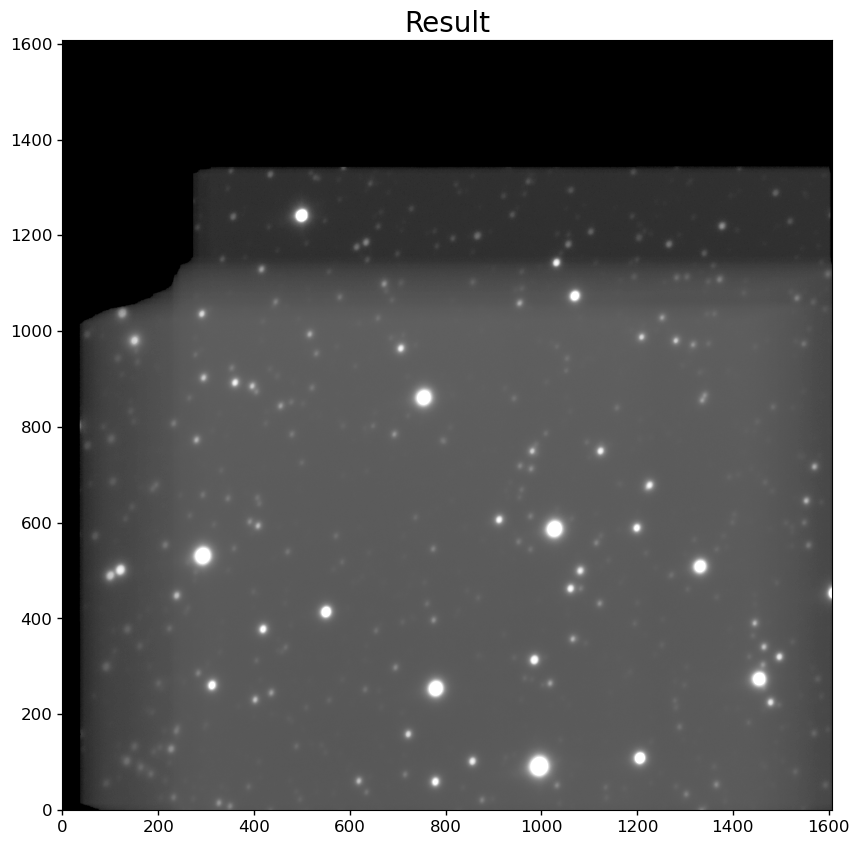

In [8]:
result_img = result_img # your result image array
print(result_img)

# normalization parameters mimicking the zscale setting on ds9
norm = ImageNormalize(result_img, interval=ZScaleInterval(nsamples=600, contrast=0.25))

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.imshow(result_img, cmap='Greys_r', origin='lower', norm=norm)
ax.set_title('Result', fontsize=20)
ax.tick_params(labelsize='large', width=1)

plt.show()

In [12]:
%cd ~/A101/Lab2/Lab2_Resources/lab2-image_processing_v0.1/

def combine_some(num):
    aligned_ls = findAllIn('./alipy_out/', 'fdb_*.fits')
    print(aligned_ls)

    # save the list for future use
    with open("./aligned_ls.txt", "w") as output:
        for i in aligned_ls:
            output.write(str(i + '\n'))

    # running ccdproc.combine() + saving resulting image
    aligned_raw = read_ccddata_ls(aligned_ls, './alipy_out/')

    result_img = ccdproc.combine(aligned_raw,
                            method='median',
                            sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                            sigma_clip_func=np.ma.average)
    result_img.meta['combined'] = True
    result_img.write('./partial_combined/combined_star2_filtAll.fits',overwrite=True)

/Users/student/A101/Lab2/Lab2_Resources/lab2-image_processing_v0.1
